In [64]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [65]:
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
MONTHS = ["apr23", "may23", "jun23", "jul23", "aug23", "sep23", "oct23", "nov23", "dec23", "jan24", "feb24", "mar24", "apr24", "may24", "jun24",  "jul24", "aug24"]  

In [66]:
monthly_token_data = {}

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    month_prices = {}
    month_volumes = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns or 'volume' not in df.columns:
                continue

            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['days_since_launch'] = df.index
            month_prices[token] = df[['days_since_launch', 'close']].set_index('days_since_launch').rename(columns={'close': token})
            month_volumes[token] = df[['days_since_launch', 'volume']].set_index('days_since_launch').rename(columns={'volume': token})
        except Exception as e:
            print(f"⚠️ Error in {token}: {e}")

    if month_prices and month_volumes:
        aligned_prices = pd.concat(month_prices.values(), axis=1, join='inner')
        aligned_volumes = pd.concat(month_volumes.values(), axis=1, join='inner')

        monthly_token_data[month] = {
            "prices": aligned_prices,
            "volumes": aligned_volumes
        }

        print(f"✅ Loaded {month}: {aligned_prices.shape[1]} tokens, {aligned_prices.shape[0]} days")
    else:
        print(f"❌ Skipped {month}: No valid token data found")


✅ Loaded apr23: 5 tokens, 60 days
✅ Loaded may23: 5 tokens, 18 days
✅ Loaded jun23: 5 tokens, 3 days
✅ Loaded jul23: 5 tokens, 60 days
✅ Loaded aug23: 5 tokens, 60 days
✅ Loaded sep23: 5 tokens, 60 days
✅ Loaded oct23: 5 tokens, 60 days
✅ Loaded nov23: 5 tokens, 60 days
✅ Loaded dec23: 5 tokens, 60 days
✅ Loaded jan24: 5 tokens, 60 days
✅ Loaded feb24: 5 tokens, 60 days
✅ Loaded mar24: 5 tokens, 60 days
✅ Loaded apr24: 5 tokens, 44 days
✅ Loaded may24: 5 tokens, 60 days
✅ Loaded jun24: 5 tokens, 60 days
✅ Loaded jul24: 5 tokens, 60 days
✅ Loaded aug24: 5 tokens, 60 days


### Lookahead Bias Portfolio

📈 apr23: Final return over 30 days = 1090.85%
⚠️ Skipping may23: Not enough days to backtest (17 days)
⚠️ Skipping jun23: Not enough days to backtest (2 days)
📈 jul23: Final return over 30 days = -7.05%
📈 aug23: Final return over 30 days = 319.88%
📈 sep23: Final return over 30 days = 313.32%
📈 oct23: Final return over 30 days = 1003.31%
📈 nov23: Final return over 30 days = 1044.03%
📈 dec23: Final return over 30 days = -1.29%
📈 jan24: Final return over 30 days = 28.4%
📈 feb24: Final return over 30 days = 363.33%
📈 mar24: Final return over 30 days = 52.06%
📈 apr24: Final return over 30 days = -34.11%
📈 may24: Final return over 30 days = 108.06%
📈 jun24: Final return over 30 days = -1.45%
📈 jul24: Final return over 30 days = 81.65%
📈 aug24: Final return over 30 days = 5.17%


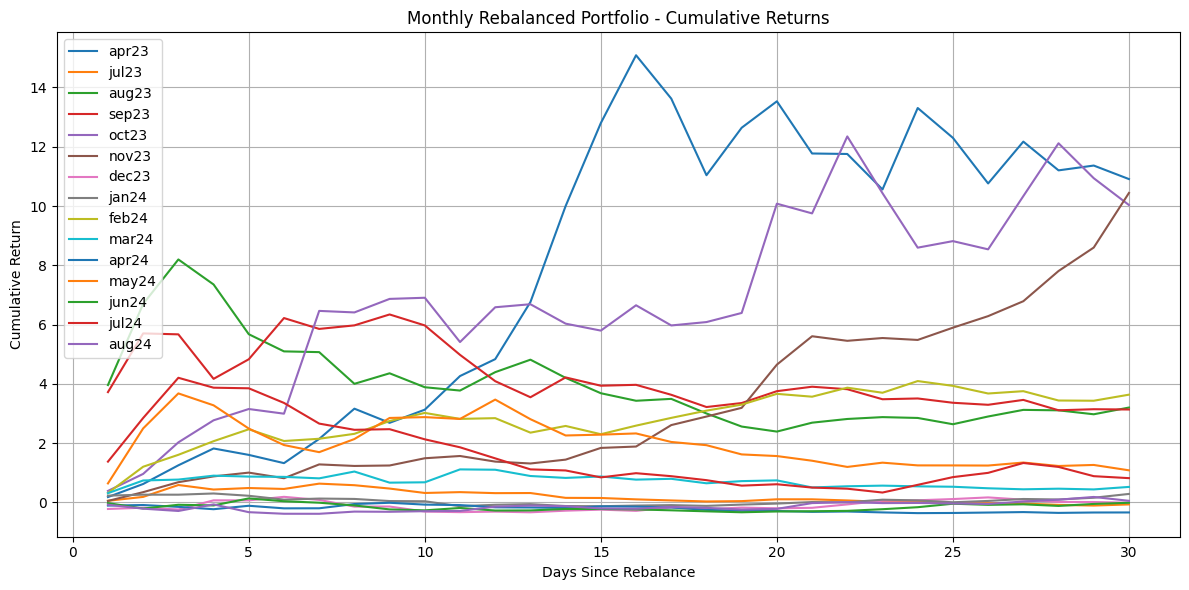

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

results = {}

# Rebalancing period in days
HOLD_DAYS = 30

for month, data in monthly_token_data.items():
    prices = data['prices'].copy()

    # Ensure prices are sorted by days_since_launch
    prices = prices.sort_index()

    # Compute daily returns for each token
    daily_returns = prices.pct_change().dropna()

    # Define rebalance point
    if daily_returns.shape[0] < HOLD_DAYS:
        print(f"⚠️ Skipping {month}: Not enough days to backtest ({daily_returns.shape[0]} days)")
        continue

    # Equal weights
    n_tokens = daily_returns.shape[1]
    weights = pd.Series(1 / n_tokens, index=daily_returns.columns)

    # Slice returns for the holding period
    held_returns = daily_returns.iloc[:HOLD_DAYS]

    # Portfolio daily returns (weighted average of token returns)
    portfolio_returns = held_returns @ weights

    # Cumulative return
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    # Store results
    results[month] = {
        'portfolio_returns': portfolio_returns,
        'cumulative_returns': cumulative_returns,
        'final_return': cumulative_returns.iloc[-1]
    }

    print(f"📈 {month}: Final return over {HOLD_DAYS} days = {round(cumulative_returns.iloc[-1]*100, 2)}%")

# Plotting all cumulative returns
plt.figure(figsize=(12, 6))
for month, res in results.items():
    plt.plot(res['cumulative_returns'], label=month)
plt.title("Monthly Rebalanced Portfolio - Cumulative Returns")
plt.xlabel("Days Since Rebalance")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### --- Lookahead Bias Portfolio (Day-0 to Day-30)

- Fully Rebalancing at the end of each month (swapping all 5 tokens)

✅ apr23: Return = 4924.88%
✅ may23: Return = 1139.80%
✅ jun23: Return = 14.73%
✅ jul23: Return = -29.64%
✅ aug23: Return = 41.20%
✅ sep23: Return = 467.76%
✅ oct23: Return = 4476.54%
✅ nov23: Return = 753.52%
✅ dec23: Return = 87.62%
✅ jan24: Return = 3.04%
✅ feb24: Return = 468.07%
✅ mar24: Return = 22.63%
✅ apr24: Return = -42.39%
✅ may24: Return = 381.45%
✅ jun24: Return = -13.70%
✅ jul24: Return = 119.92%
✅ aug24: Return = 305.56%


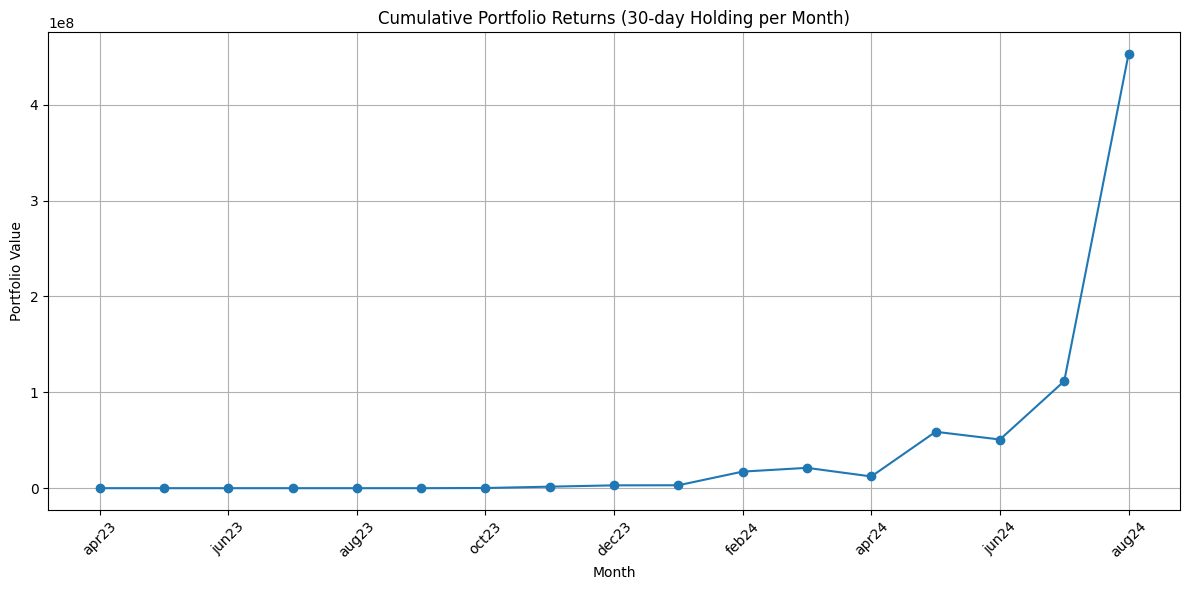

In [68]:
portfolio_returns = []
portfolio_history = []

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    token_returns = []

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            df = df.sort_values("timestamp").reset_index(drop=True)

            if 'close' not in df.columns or len(df['close']) < 2:
                continue

            # Take up to first 30 days if available
            prices = df['close'].iloc[:30]
            if len(prices) < 2:
                continue

            ret = (prices.iloc[-1] - prices.iloc[0]) / prices.iloc[0]
            token_returns.append(ret)
        except Exception as e:
            print(f"⚠️ Error with token {token} in {month}: {e}")

    if token_returns:
        avg_return = np.mean(token_returns)
        portfolio_returns.append(avg_return)
        portfolio_history.append({
            "month": month,
            "return": avg_return,
            "tokens": [os.path.basename(f).replace(".csv", "") for f in files]
        })
        print(f"✅ {month}: Return = {avg_return:.2%}")
    else:
        print(f"❌ {month}: No valid return data")

# Cumulative return plot
returns_df = pd.DataFrame(portfolio_history)
cumulative = (1 + pd.Series(portfolio_returns)).cumprod()
cumulative.index = [entry["month"] for entry in portfolio_history]

plt.figure(figsize=(12, 6))
cumulative.plot(marker='o')
plt.title("Cumulative Portfolio Returns (30-day Holding per Month)")
plt.ylabel("Portfolio Value")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### --- Non-Lookahead Bias Portfolio (Day-30 to Day-60)

- Fully Rebalancing at the end of each month (swapping all 5 tokens)

✅ apr23: Return = -48.87%
✅ may23: Return = -6.84%
✅ jun23: Return = 17.85%
✅ jul23: Return = -4.32%
✅ aug23: Return = -3.90%
✅ sep23: Return = 99.78%
✅ oct23: Return = 36.92%
✅ nov23: Return = -30.67%
✅ dec23: Return = -10.51%
✅ jan24: Return = 43.66%
✅ feb24: Return = -44.33%
✅ mar24: Return = -27.81%
✅ apr24: Return = -12.71%
✅ may24: Return = -37.31%
✅ jun24: Return = -38.56%
✅ jul24: Return = -38.09%
✅ aug24: Return = 40.12%
✅ sep24: Return = -12.57%
✅ oct24: Return = -8.95%
✅ nov24: Return = -21.84%
✅ dec24: Return = -36.80%
✅ jan25: Return = -15.82%
✅ feb25: Return = -28.45%
✅ mar25: Return = -25.21%
✅ apr25: Return = -2.72%


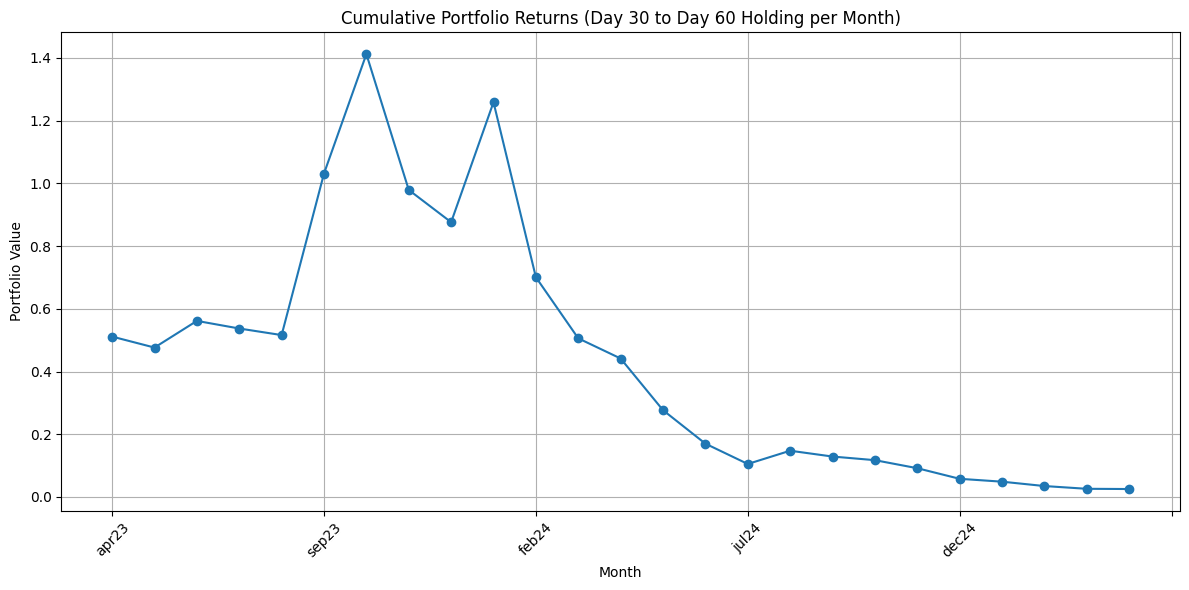

In [26]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

portfolio_returns = []
portfolio_history = []

for month in MONTHS:
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    token_returns = []

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            df = df.sort_values("timestamp").reset_index(drop=True)

            if 'close' not in df.columns or len(df['close']) < 60:
                continue  # Ensure at least 60 days of data

            # Take days 30 to 60 (index 29 to 59)
            prices = df['close'].iloc[29:60]
            if len(prices) < 2:
                continue

            ret = (prices.iloc[-1] - prices.iloc[0]) / prices.iloc[0]
            token_returns.append(ret)
        except Exception as e:
            print(f"⚠️ Error with token {token} in {month}: {e}")

    if token_returns:
        avg_return = np.mean(token_returns)
        portfolio_history.append({  # Append to portfolio_history, not portfolio_returns
            "month": month,
            "return": avg_return,
            "tokens": [os.path.basename(f).replace(".csv", "") for f in files]
        })
        print(f"✅ {month}: Return = {avg_return:.2%}")
    else:
        print(f"❌ {month}: No valid return data")

# Cumulative return plot
returns_df = pd.DataFrame(portfolio_history)
cumulative = (1 + returns_df['return']).cumprod()
cumulative.index = returns_df['month']

plt.figure(figsize=(12, 6))
cumulative.plot(marker='o')
plt.title("Cumulative Portfolio Returns (Day 30 to Day 60 Holding per Month)")
plt.ylabel("Portfolio Value")
plt.xlabel("Month")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [70]:
returns = [
    -0.4887, -0.0684, 0.1785, -0.0432, -0.0390, 0.9978, 0.3692, -0.3067,
    -0.1051, 0.4366, -0.4433, -0.2781, -0.1271, -0.3731, -0.3856, -0.3809, 0.4012
]
cumulative = 1
for r in returns:
    cumulative *= (1 + r)
total_return = cumulative - 1
print(f"Total Return: {total_return * 100:.2f}%")

Total Return: -85.25%


### Partial Rebalancing

🔍 Loading files...
📦 Loaded 5 tokens.
📊 Top tokens by volume in aug23: ['PNDC', 'PEPE', 'DMT', 'SHIA', '똥코인']

🎯 Tokens with valid data for Lookahead Bias (Oct 0–29): ['PNDC', 'PEPE', 'DMT', 'SHIA', '똥코인']
🎯 Tokens with valid data for No Lookahead Bias (Nov 30–60): ['PNDC', 'PEPE', 'DMT', 'SHIA', '똥코인']


/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_16310/1297227039.py:108: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


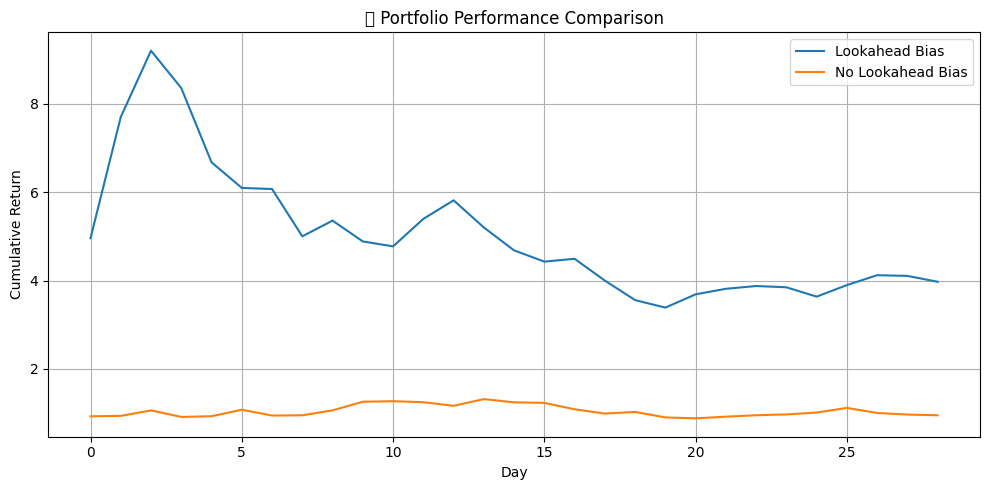


📊 Lookahead Bias Portfolio:
        Total Return: 297.17%
   Annualized Return: 3458017202.27%
        Sharpe Ratio: 3.50
        Max Drawdown: -63.16%

📊 No Lookahead Bias Portfolio:
        Total Return: -4.70%
   Annualized Return: -45.43%
        Sharpe Ratio: 0.45
        Max Drawdown: -32.97%


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
LOOKAHEAD_START, LOOKAHEAD_END = 0, 29
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 60
MONTH = "aug23" 

# === LOAD DATA ===
files = glob.glob(f"{BASE_PATH}/{MONTH}/*.csv")
price_data = {}
volume_data = {}

print("🔍 Loading files...")
for file in files:
    token = os.path.basename(file).replace(".csv", "")
    try:
        df = pd.read_csv(file)
        df.columns = df.columns.str.lower()
        if 'close' not in df.columns or 'volume' not in df.columns:
            print(f"⚠️ Skipping {token}: missing 'close' or 'volume'")
            continue
        df = df.sort_values(by='timestamp').reset_index(drop=True)
        df['day'] = df.index
        price_data[token] = df.set_index('day')['close']
        volume_data[token] = df.set_index('day')['volume']
    except Exception as e:
        print(f"❌ Error loading {token}: {e}")

print(f"📦 Loaded {len(price_data)} tokens.")

# === TOTAL VOLUME RANKING ===
volume_df = pd.DataFrame(volume_data)
if volume_df.empty:
    print("❌ No volume data available. Check folder path or CSV format.")
    exit()

total_volume = volume_df.loc[LOOKAHEAD_START:LOOKAHEAD_END].sum()
top_tokens = total_volume.sort_values(ascending=False).head(10).index.tolist()
print(f"📊 Top tokens by volume in {MONTH}: {top_tokens}")

# === FILTER TOKENS WITH DATA IN WINDOW ===
def filter_tokens_with_valid_window(tokens, df_dict, start_day, end_day):
    return [
        token for token in tokens
        if token in df_dict and df_dict[token].loc[start_day:end_day].notna().all()
    ]

lookahead_tokens = filter_tokens_with_valid_window(top_tokens, price_data, LOOKAHEAD_START, LOOKAHEAD_END)
nobias_tokens = filter_tokens_with_valid_window(top_tokens, price_data, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)

print(f"\n🎯 Tokens with valid data for Lookahead Bias (Oct {LOOKAHEAD_START}–{LOOKAHEAD_END}): {lookahead_tokens}")
print(f"🎯 Tokens with valid data for No Lookahead Bias (Nov {NO_LOOKAHEAD_START}–{NO_LOOKAHEAD_END}): {nobias_tokens}")

# === BACKTESTING ===
def backtest(tokens, start_day, end_day):
    prices = pd.DataFrame({t: price_data[t].loc[start_day:end_day] for t in tokens})
    returns = prices.pct_change().dropna()
    weights = np.ones(len(tokens)) / len(tokens)
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Metrics
    total_return = cum_returns.iloc[-1] - 1
    ann_return = (cum_returns.iloc[-1])**(365 / len(cum_returns)) - 1
    volatility = daily_returns.std()
    sharpe = daily_returns.mean() / volatility * np.sqrt(365)
    max_dd = (cum_returns / cum_returns.cummax() - 1).min()

    metrics = {
        "Total Return": f"{total_return * 100:.2f}%",
        "Annualized Return": f"{ann_return * 100:.2f}%",
        "Sharpe Ratio": f"{sharpe:.2f}",
        "Max Drawdown": f"{max_dd * 100:.2f}%"
    }

    return cum_returns, daily_returns, metrics

# === RUN BACKTESTS ===
results = {}

if lookahead_tokens:
    cr_look, dr_look, metrics_look = backtest(lookahead_tokens, LOOKAHEAD_START, LOOKAHEAD_END)
    results['Lookahead Bias'] = (cr_look, dr_look, metrics_look)
else:
    print("❌ No tokens with full data for Lookahead Bias window.")

if nobias_tokens:
    cr_nobias, dr_nobias, metrics_nobias = backtest(nobias_tokens, NO_LOOKAHEAD_START, NO_LOOKAHEAD_END)
    results['No Lookahead Bias'] = (cr_nobias, dr_nobias, metrics_nobias)
else:
    print("❌ No tokens with full data for No Lookahead Bias window.")

# === PLOT ===
if results:
    plt.figure(figsize=(10, 5))
    for label, (cum_returns, _, _) in results.items():
        plt.plot(cum_returns.values, label=label)
    plt.title("📈 Portfolio Performance Comparison")
    plt.xlabel("Day")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === METRICS ===
for label, (_, _, metrics) in results.items():
    print(f"\n📊 {label} Portfolio:")
    for k, v in metrics.items():
        print(f"{k:>20}: {v}")


### Loop for calculating returns for all the months so far 


📅 Processing month: apr23
✅ apr23: Return = -42.25%, Tokens Used = 5

📅 Processing month: may23
✅ may23: Return = 112.71%, Tokens Used = 4

📅 Processing month: jun23
✅ jun23: Return = 3.88%, Tokens Used = 4

📅 Processing month: jul23
✅ jul23: Return = -1.99%, Tokens Used = 5

📅 Processing month: aug23
✅ aug23: Return = -4.70%, Tokens Used = 5

📅 Processing month: sep23
✅ sep23: Return = 74.86%, Tokens Used = 5

📅 Processing month: oct23
✅ oct23: Return = 32.59%, Tokens Used = 5

📅 Processing month: nov23
✅ nov23: Return = -33.87%, Tokens Used = 5

📅 Processing month: dec23
✅ dec23: Return = 6.70%, Tokens Used = 5

📅 Processing month: jan24
✅ jan24: Return = 41.72%, Tokens Used = 5

📅 Processing month: feb24
✅ feb24: Return = -42.36%, Tokens Used = 5

📅 Processing month: mar24
✅ mar24: Return = 28.22%, Tokens Used = 5

📅 Processing month: apr24
✅ apr24: Return = -2.35%, Tokens Used = 5

📅 Processing month: may24
✅ may24: Return = -30.70%, Tokens Used = 5

📅 Processing month: jun24
✅ ju

/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_16310/3403693414.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_16310/3403693414.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()
/var/folders/5s/msqhxw9x46gfs6_9m2x8qxch0000gn/T/ipykernel_16310/3403693414.py:50: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to cal

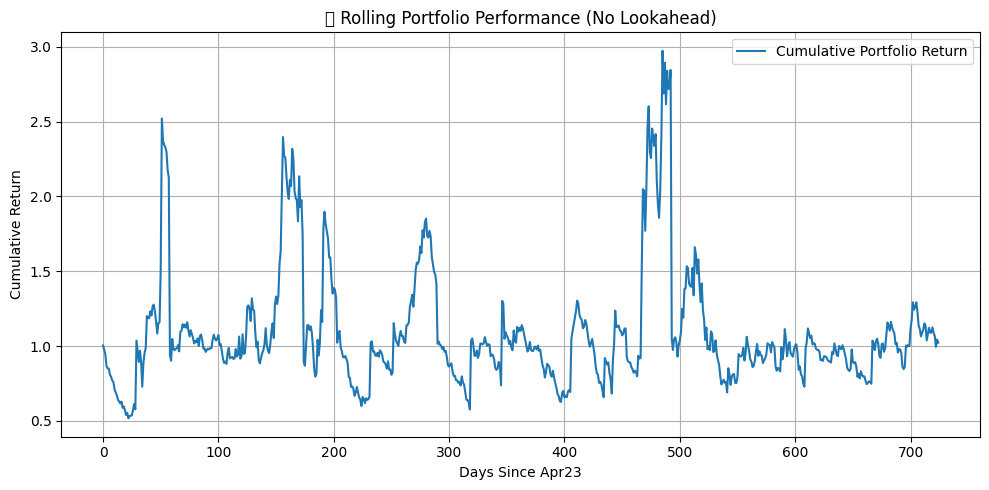


📊 Monthly No-Lookahead Performance Summary:
       Return (%)
Month            
apr23      -42.25
may23      112.71
jun23        3.88
jul23       -1.99
aug23       -4.70
sep23       74.86
oct23       32.59
nov23      -33.87
dec23        6.70
jan24       41.72
feb24      -42.36
mar24       28.22
apr24       -2.35
may24      -30.70
jun24      -34.20
jul24      -20.23
aug24      184.59
sep24       17.83
oct24      -20.31
nov24       -4.13
dec24      -27.18
jan25       -6.76
feb25      -25.24
mar25      -13.99
apr25        2.30


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

# === CONFIGURATION ===
BASE_PATH = "/Users/harshit/Downloads/Research-Commons-Quant/automated-memetoken-index-pipeline/dataframes"
NO_LOOKAHEAD_START, NO_LOOKAHEAD_END = 30, 60
MONTHS = ["apr23", "may23", "jun23", "jul23", "aug23", "sep23", "oct23", "nov23", "dec23", 
          "jan24", "feb24", "mar24", "apr24", "may24", "jun24", "jul24", "aug24", "sep24", "oct24", "nov24", "dec24", "jan25", "feb25", "mar25", "apr25"]

monthly_returns = {}
all_cum_returns = []

for month in MONTHS:
    print(f"\n📅 Processing month: {month}")
    files = glob.glob(f"{BASE_PATH}/{month}/*.csv")
    price_data = {}

    for file in files:
        token = os.path.basename(file).replace(".csv", "")
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.lower()
            if 'close' not in df.columns:
                continue
            df = df.sort_values(by='timestamp').reset_index(drop=True)
            df['day'] = df.index
            price_data[token] = df.set_index('day')['close']
        except Exception as e:
            print(f"❌ Error loading {token}: {e}")

    # Ensure we have exactly 5 tokens
    if len(price_data) != 5:
        print(f"⚠️ Skipping {month}: found {len(price_data)} tokens instead of 5.")
        continue

    # Slice day 30 to 60 for each token (keep whatever is available)
    prices = pd.DataFrame({
        t: s.loc[NO_LOOKAHEAD_START:NO_LOOKAHEAD_END] 
        for t, s in price_data.items()
    }).dropna(axis=1, how='all')  # drop tokens with all NaNs in that window

    if prices.shape[1] == 0:
        print("⚠️ No token has usable data in day 30–60 window.")
        continue

    # Calculate returns
    returns = prices.pct_change().dropna()
    weights = np.ones(prices.shape[1]) / prices.shape[1]
    daily_returns = returns.dot(weights)
    cum_returns = (1 + daily_returns).cumprod()

    # Save
    monthly_returns[month] = cum_returns.iloc[-1] - 1
    all_cum_returns.append(cum_returns)

    print(f"✅ {month}: Return = {monthly_returns[month]*100:.2f}%, Tokens Used = {prices.shape[1]}")

# === PLOT CUMULATIVE RETURNS ===
if all_cum_returns:
    joined = pd.concat(all_cum_returns, ignore_index=True)
    plt.figure(figsize=(10, 5))
    plt.plot(joined, label="Cumulative Portfolio Return")
    plt.title("📈 Rolling Portfolio Performance (No Lookahead)")
    plt.xlabel("Days Since Apr23")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

# === SUMMARY ===
summary_df = pd.DataFrame.from_dict(monthly_returns, orient='index', columns=["Return"])
summary_df.index.name = "Month"
summary_df["Return (%)"] = summary_df["Return"] * 100
print("\n📊 Monthly No-Lookahead Performance Summary:")
print(summary_df[["Return (%)"]].round(2))


In [25]:
from functools import reduce

# Monthly returns as decimal values
monthly_returns = [
    -0.4225, 1.1271, 0.0388, -0.0199, -0.0470, 0.7486, 0.3259, -0.3387,
    0.0670, 0.4172, -0.4236, 0.2822, -0.0235, -0.3070, -0.3420, -0.2023,
    1.8459, 0.1783, -0.2031, -0.0413, -0.2718, -0.0676, -0.2524, -0.1399, 0.0230
]

# Compound returns
total_return = reduce(lambda x, y: x * (1 + y), monthly_returns, 1) - 1

# Convert to percentage
total_return_percentage = total_return * 100
print(f"Total Return: {total_return_percentage:.2f}%")


Total Return: -17.00%
